# This repo is for performing EDA on the data

## Table of contents
- [Setup](#setup)
- [Loading and analyzing the data](#loading-and-analyzing-the-data)
    - [Scratching the surface](#scratching-the-surface)
        - [Assumed column definitions](#Assumed-column-definitions)
        - [Data summary](#Data-summary)
        - [Drop Project ID](#drop-project-id)
        - [The distribution of the data](#The-distribution-of-the-data)
            - [Visualization](#Visualization)
        - [Column by column initial analysis](#Column-by-column-initial-analysis)
    - [Digging deeper into the numerical cols](#Digging-deeper-into-the-numerical-cols)
        - [Value uniqueness per column](#Value-uniqueness-per-column)
        - [How are the entries related?](#How-are-the-entries-related?)
            - [Item ID and Purchase Order ID](#Item-ID-and-Purchase-Order-ID)
                - [Tro to infer Item Name from Purchase Order](#try-to-infer-item-name-from-purchase-order)
            - [Product IDs](#Product-IDs)
            - [🚨 ***Purchase Details Hiearchy***](#Purchase-Details-Hiearchy)
        - [Total Bcy and Sub Total Bcy](#Total-Bcy-and-Sub-Total-Bcy)
            - [Nailed It.](#Nailed-it.)
        - [Currency Code](#Currency-Code)
            - [Conclusion](#Conclusion)
        - [Account ID](#Account-ID)
            - [Findings](#Findings)
        - [Tax ID](#tax-id)
            - [Results](#Results)
    - [Dealing with null values](#Dealing-with-null-values)
- [Saving the modified dataset](#saving-the-modified-dataset)




# Setup

In [159]:
# Setup the envionment via these CLIs
"""
py -3.10 -m venv .venv
.venv\Scripts\activate
pip install -r requirements.txt
"""

'\npy -3.10 -m venv .venv\n.venv\\Scripts\x07ctivate\npip install -r requirements.txt\n'

In [160]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading and analyzing the data

In [161]:
data_path = "../data/purchase-order-items.xlsx"
df_original = pd.read_excel(data_path)

## Scratching the surface
I usually start with data summary and stats, then dig deeper into each column

### Assumed column definitions 
(modified after later analysis)
- Item ID - a unique key for each item purchase entry
- Item Name - a textual description of the purchased item/items
- Qunatity - the number of items purchased of the same type
- Total Bcy - Amount paid in Base Currency for purchase
- Sub Total Bcy = Adjusted Total Bcy
- Purchase Order ID - A reference for bulk purchases
- Product ID - Unkown relationship with the rest of the data, assumed to represent the item purchased numerically or the product the item was purchased to create/supply
- Currency Code - paid in SAR/USD
- Account ID - account used to make the purchase/company the purchase was made for (probably the former)
- Tax ID - ID used for tax reporting
- Project ID - unknown, no real values; dropped

### Data summary

In [162]:
df_original.head(2)

,Item ID,Item Name,Quantity,Total Bcy,Sub Total Bcy,Purchase Order ID,Product ID,Currency Code,Account ID,Tax ID,Project ID
0,3263831000000089042,NaN,75.21,227510.25,227510.25,3263831000000089040,NaN,SAR,3263831000000034003,3.263831e+18,NaN
1,3263831000000089046,NaN,15.00,47250.00,47250.00,3263831000000089040,NaN,SAR,3263831000000034003,3.263831e+18,NaN


In [163]:
df_original.tail(2)

,Item ID,Item Name,Quantity,Total Bcy,Sub Total Bcy,Purchase Order ID,Product ID,Currency Code,Account ID,Tax ID,Project ID
3148,3263831000016208285,حديد تسليح مجدول سعودي سابك 12 مم * 12 م,30.0,69000.0,69000.0,3263831000016208283,3.263831e+18,SAR,3263831000000034003,3.263831e+18,NaN
3149,3263831000018023011,حديد تسليح مجدول سعودي سابك 16 مم * 12 م,30.0,69000.0,69000.0,3263831000018023005,3.263831e+18,SAR,3263831000000034003,3.263831e+18,NaN


We can see that some values (and some columns) are missing, but how badly?

In [164]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Item ID            3150 non-null   int64  
 1   Item Name          2910 non-null   object 
 2   Quantity           3150 non-null   float64
 3   Total Bcy          3150 non-null   float64
 4   Sub Total Bcy      3150 non-null   float64
 5   Purchase Order ID  3150 non-null   int64  
 6   Product ID         2910 non-null   float64
 7   Currency Code      3150 non-null   object 
 8   Account ID         3150 non-null   int64  
 9   Tax ID             3085 non-null   float64
 10  Project ID         0 non-null      float64
dtypes: float64(6), int64(3), object(2)
memory usage: 270.8+ KB


In [165]:
df_original.isnull().sum()

Item ID                 0
Item Name             240
Quantity                0
Total Bcy               0
Sub Total Bcy           0
Purchase Order ID       0
Product ID            240
Currency Code           0
Account ID              0
Tax ID                 65
Project ID           3150
dtype: int64

Alright so overall the data misses some values but not too much, specifically:
- Item Name: 240 values 
- Product ID, similarly: 240 (could be correlated columns)
- Tax ID: 65
- Project ID: completely empty

### Drop Project ID
We'll drop the column and focus on the rest as it has no value in analysis

In [166]:
df = df_original.drop("Project ID", axis=1)

### The distribution of the data

In [167]:
df.describe()

,Item ID,Quantity,Total Bcy,Sub Total Bcy,Purchase Order ID,Product ID,Account ID,Tax ID
count,3.150000e+03,3150.000000,3.150000e+03,3.150000e+03,3.150000e+03,2.910000e+03,3.150000e+03,3.085000e+03
mean,3.263831e+18,475.470797,4.853890e+04,4.854089e+04,3.263831e+18,3.263831e+18,3.263831e+18,3.263831e+18
std,7.627889e+06,2737.024475,1.046032e+05,1.046032e+05,7.629406e+06,7.281519e+06,1.174301e+03,1.536249e+03
min,3.263831e+18,0.150000,0.000000e+00,0.000000e+00,3.263831e+18,3.263831e+18,3.263831e+18,3.263831e+18
25%,3.263831e+18,7.000000,2.001473e+03,2.001473e+03,3.263831e+18,3.263831e+18,3.263831e+18,3.263831e+18
50%,3.263831e+18,30.000000,1.235133e+04,1.237840e+04,3.263831e+18,3.263831e+18,3.263831e+18,3.263831e+18
75%,3.263831e+18,130.000000,5.599900e+04,5.599900e+04,3.263831e+18,3.263831e+18,3.263831e+18,3.263831e+18
max,3.263831e+18,70000.000000,1.519000e+06,1.519000e+06,3.263831e+18,3.263831e+18,3.263831e+18,3.263831e+18


#### Visualization
hmm the values are too large to see get intrepetable stats, let's visualize instead

The numerical columns are: ['Item ID' 'Quantity' 'Total Bcy' 'Sub Total Bcy' 'Purchase Order ID'
 'Product ID' 'Account ID' 'Tax ID']


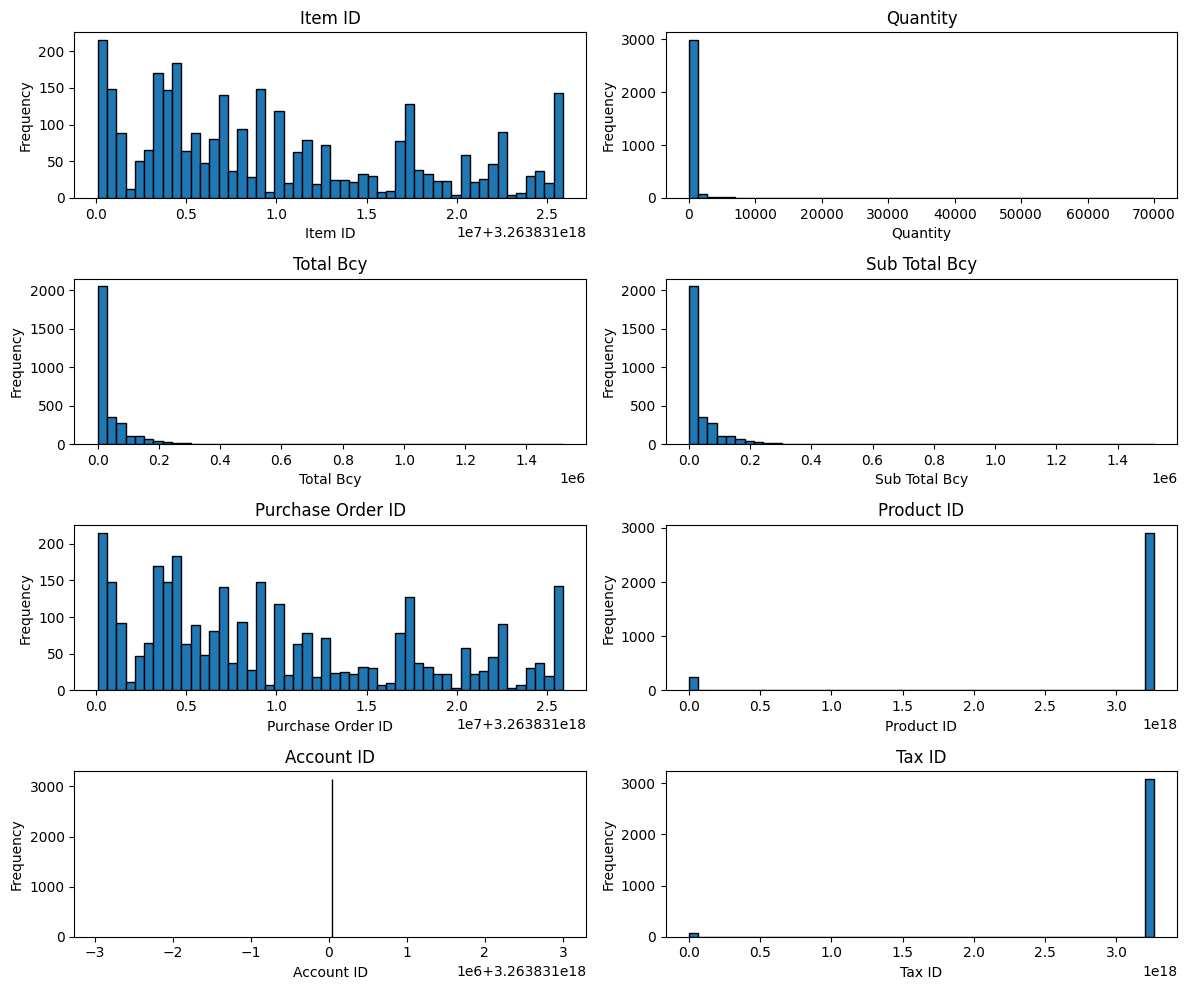

In [168]:
# AI-Assisted Cell to generate plots
num_cols = df.select_dtypes(include='number').columns
print("The numerical columns are:", num_cols.values)

# Create a new df with NaN replaced by 0
num_df = df[num_cols].astype(float).fillna(0)

fig, axes = plt.subplots(4, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, col in zip(axes, num_df.columns):
    vals = num_df[col].to_numpy()
    ax.hist(vals, bins=50, edgecolor='k')
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### Column by column initial analysis
- Item ID appears to be reused quite often, but still has a wide range which indicates a lot of different items were purchased but many were repeated purchases.
- Quantity has a huge right tail (right skewed) some outliers were purchased in large quantities but most lie below 5000.
- Total Bcy and Sub Total Bcy are similarly right skewed. They appear to have a very similar distrubtion.
- Purchase Order ID appears to follow the same distribution as Item ID. Are these duplicates?
- Product ID is overwhelmingly one value, the rest could've been zeroed out nulls.
- Account ID is strange, need to invistigate more.
- Tax ID is also overwhelmingly one value, the others are nulls?

## Digging deeper into the numerical cols
The analysis above prompts further invistigation into each column and some columns' correlation

### Value uniqueness per column

In [169]:
# No. of unique values per column
df.nunique(axis=0)

Item ID              3150
Item Name            2302
Quantity              441
Total Bcy            2246
Sub Total Bcy        2246
Purchase Order ID     531
Product ID            896
Currency Code           2
Account ID              2
Tax ID                  1
dtype: int64

Analysis of uniqueness:
- **Item ID** has completely unique values, not useful for analysis, but will be used as an identifier for the entries (like a unique key)
- **Item Name** has some repeated entries, yet every entry has a unique Item ID? This is somewhat inconsistent
---
- **Purchase Order ID** many repeats, could be groups of items purchased in one order - their IDs look similar to Item IDs but won't dwell on it
- **Product ID** has this few number of unique values? But I thought it would be consistent with Item Names to identify the items sinc Item IDs are all unique
---
- **Total Bcy** and **Sub Total Bcy** have the same number of unique values, correlated columns for sure
- **Quantity** has many repeats, that's fine, it's specific to the purchases
- **Currency Code** - SAR & USD
- **Account ID** - only two IDs and surely no null values as seen previously
- **Tax ID** has one unique value, which means the 65 other values are nulls

### How are the entries related?

#### Item ID and Purchase Order ID
Let's see if Items with Null names are at least part of known Purchases Orders so we can reverse engineer what they could be

In [170]:
# AI-Assisted code block to quantify the reach of null values on purchase orders
df_po = df.copy()

# robust “missing” mask for Item Name
item_missing = df_po["Item Name"].isna() | df_po["Item Name"].astype(str).str.strip().eq("")
df_po["item_missing"] = item_missing

# PO-level summary: how many known vs missing per PO
po_summary = (
    df_po.groupby("Purchase Order ID", dropna=False)
        .agg(n_rows=("Item Name","size"),
             n_missing=("item_missing","sum"))
        .assign(n_known=lambda x: x["n_rows"] - x["n_missing"],
                p_missing=lambda x: x["n_missing"]/x["n_rows"],
                mixed=lambda x: (x["n_known"]>0) & (x["n_missing"]>0))
        .sort_values(["mixed","p_missing","n_rows"], ascending=[False, False, False])
)

# rows with missing Item Name that belong to mixed POs (what you care about)
mixed_pos = po_summary.index[po_summary["mixed"]].tolist()
todo = df_po.loc[df_po["item_missing"] & df_po["Purchase Order ID"].isin(mixed_pos)].copy()

# --- concise, intuitive summary ---

n_pos = len(po_summary)
n_all_missing = (po_summary["n_known"] == 0).sum()
n_mixed = po_summary["mixed"].sum()
n_clean = (po_summary["n_missing"] == 0).sum()

med_n_rows = int(po_summary["n_rows"].median())
med_n_missing = int(po_summary["n_missing"].median())
med_n_known = int(po_summary["n_known"].median())
med_p_missing = float(po_summary["p_missing"].median())

print("=== Purchase Orders Overview ===")
print(f"Total POs: {n_pos}")
print(f"POs with NO item names at all: {n_all_missing}")
print(f"POs with MIXED known/missing: {n_mixed}")
print(f"POs fully clean (no missing): {n_clean}")

print("\n=== Typical PO (medians) ===")
print(f"Rows per PO (median): {med_n_rows}")
print(f"Missing rows per PO (median): {med_n_missing}")
print(f"Known rows per PO (median): {med_n_known}")
print(f"Missing fraction per PO (median): {med_p_missing:.3f}")

print("\n=== Action Items ===")
print(f"Rows needing attention (missing Item Name in mixed POs): {len(todo)}")
if len(todo) > 0:
    print(todo.head(min(5, len(todo))))




=== Purchase Orders Overview ===
Total POs: 531
POs with NO item names at all: 54
POs with MIXED known/missing: 2
POs fully clean (no missing): 475

=== Typical PO (medians) ===
Rows per PO (median): 3
Missing rows per PO (median): 0
Known rows per PO (median): 3
Missing fraction per PO (median): 0.000

=== Action Items ===
Rows needing attention (missing Item Name in mixed POs): 2
                 Item ID Item Name  Quantity  Total Bcy  Sub Total Bcy  \
503  3263831000002621153       NaN       1.0        3.5            3.5   
510  3263831000003059878       NaN       1.0        7.0            7.0   

       Purchase Order ID  Product ID Currency Code           Account ID  \
503  3263831000002621149         NaN           SAR  3263831000000034003   
510  3263831000002728005         NaN           SAR  3263831000000000409   

           Tax ID  item_missing  
503  3.263831e+18          True  
510  3.263831e+18          True  


So the most important things to take away from the analysis above are:
- 54 Purchase orders have no item description at all. These will be marked us unknown and analyzed alone
- 2 Item Names may be salvagable from the purchase orders they are part of (see below)


##### Try to infer Item Name from Purchase Order

In [171]:
# The Bcy differs largely and only one other item purchased; no information gained 
df[df["Purchase Order ID"] == 3263831000002621149]

,Item ID,Item Name,Quantity,Total Bcy,Sub Total Bcy,Purchase Order ID,Product ID,Currency Code,Account ID,Tax ID
502,3263831000002621151,10 MM STEEL 60GR,79.05,173910.0,173910.0,3263831000002621149,3.263831e+18,SAR,3263831000000034003,3.263831e+18
503,3263831000002621153,NaN,1.00,3.5,3.5,3263831000002621149,NaN,SAR,3263831000000034003,3.263831e+18


In [172]:
# The Bcy differs largely and reported under a different Account ID.
df[df["Purchase Order ID"] == 3263831000002728005]

,Item ID,Item Name,Quantity,Total Bcy,Sub Total Bcy,Purchase Order ID,Product ID,Currency Code,Account ID,Tax ID
505,3263831000002728009,Cut & Bend Rebar 10 mm,40.0,96000.0,96000.0,3263831000002728005,3.263831e+18,SAR,3263831000000034003,3.263831e+18
506,3263831000002728011,Cut & Bend Rebar 12 mm,60.0,135000.0,135000.0,3263831000002728005,3.263831e+18,SAR,3263831000000034003,3.263831e+18
507,3263831000002728013,Cut & Bend Rebar 14 mm,31.0,69750.0,69750.0,3263831000002728005,3.263831e+18,SAR,3263831000000034003,3.263831e+18
508,3263831000002728007,Cut & Bend Rebar 8 mm,50.0,120000.0,120000.0,3263831000002728005,3.263831e+18,SAR,3263831000000034003,3.263831e+18
509,3263831000002728015,Cut & Bend Rebar 16 mm,26.0,58500.0,58500.0,3263831000002728005,3.263831e+18,SAR,3263831000000034003,3.263831e+18
510,3263831000003059878,NaN,1.0,7.0,7.0,3263831000002728005,NaN,SAR,3263831000000000409,3.263831e+18


Theses entires could be related to the other items within the purchases, but as clear outliers, they could cause the model to underperform if kept
*Decision: treat as unkown Item Name entries*

#### Product IDs

In [173]:
# AI-Assisted block of code to see the relationship between Product IDs and Item Names
# Number of unique item names per product
item_per_product = df.groupby("Product ID")["Item Name"]
item_per_product_nunique = item_per_product.nunique()

# Products with >1 unique item name
conflicts = item_per_product_nunique[item_per_product_nunique > 1]

print("Total products:", len(item_per_product_nunique))
print("Products with conflicting item names:", len(conflicts))

Total products: 896
Products with conflicting item names: 537


There are 896 unique product IDs, 537 of which are associated with multiple purchased items, what is their relationship?

*Need to create a tab to view the relationship between Product IDs and their associated Item Names*

In [174]:
# AI-Assisted Cell to see a few of the conflicting entries

# Product IDs that have >1 unique item name
conflict_ids = conflicts.index

# See all item names grouped by each conflicting product ID
conflict_details = df[df["Product ID"].isin(conflict_ids)] \
    .groupby("Product ID")["Item Name"].unique()

# Print one example product ID and its item names
example_ids = conflict_ids[0:5]
with pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
    print("Item Names grouped by Product ID:", conflict_details.loc[example_ids])

Item Names grouped by Product ID: Product ID
3.263831e+18                                                                                                                                                                                                                        [HEB 200X200X15X9MMX12MTR, HEB 280X280X10.5X18MMX12MTR]
3.263831e+18                                                        [B.SHEET 1.5X6 MTRX20 MM, HR Sheet 5.8x1000x2000mm, HR Sheet 3.0x1000x2000mm, مربع حديد مقاس 16*16 مم سماكة 1.5 مم طول 6 م, مبروم املس 10*6000 مم, ASTM C-20 SRC Screed, 350kg/M3 125+/- Max agg. Size 10 (unit is M3)]
3.263831e+18                                                                              [IPE 300X150X7.1X10.7X12MTR, ماسورة حديد مقاس 1.5 بوصة سماكة 2.8 مم طول 6 م, ماسورة حديد مقاس 1 بوصة سماكة 1.5 مم طول 6 م, صاج حديد أسود مقاس 1000*2000 مم سماكة مم 9.80, مبسط حديد 40*8*6000 مم]
3.263831e+18                                                                                           

**Verdict:** the product IDs don't seem to relate to the items directly but rather what they are used for, i.e., the product they create.

I could use product ID to categorize the items purchased, let's visualize this a bit more:

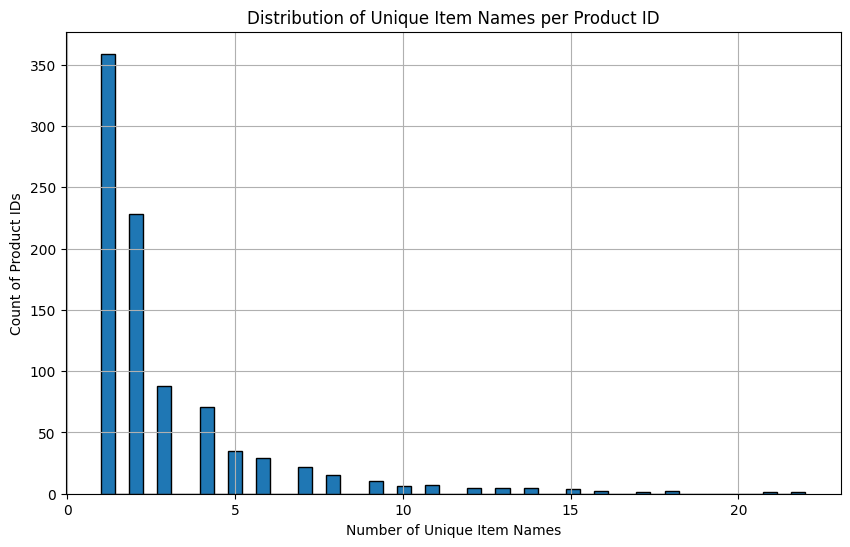

In [175]:
plt.figure(figsize=(10, 6))
plt.hist(item_per_product_nunique, bins=50, edgecolor='k')
plt.title("Distribution of Unique Item Names per Product ID")
plt.xlabel("Number of Unique Item Names")
plt.ylabel("Count of Product IDs")
plt.grid(True)
plt.show()

Most items appear to be purchased for a unique product, but many are grouped under certain Product IDs

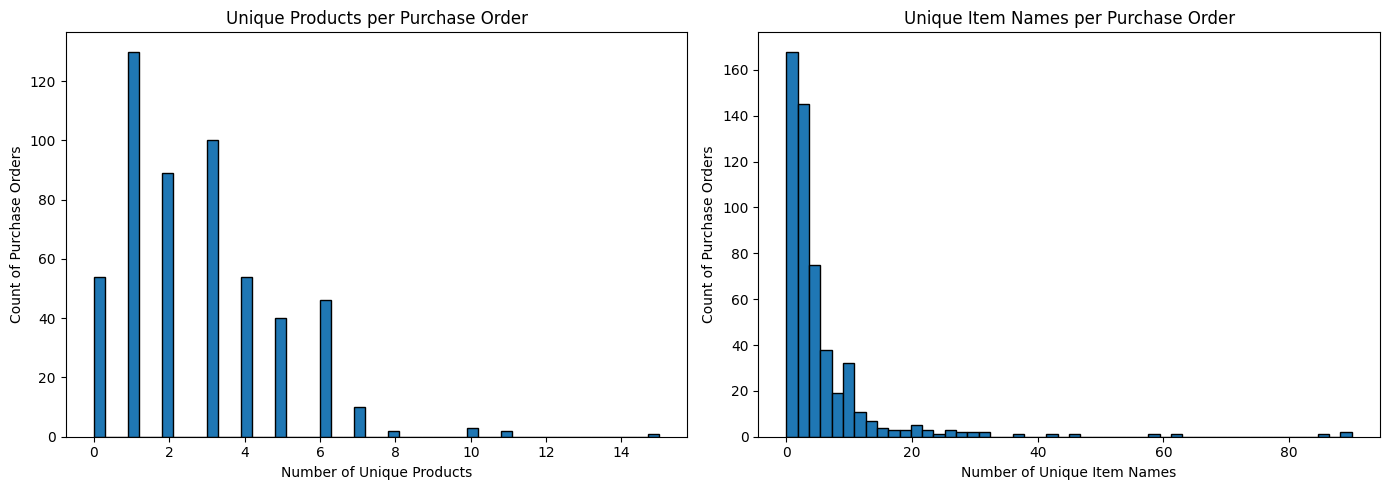

In [176]:
# Unique product count per purchase order
products_per_order = df.groupby("Purchase Order ID")["Product ID"].nunique()

# Unique item name count per purchase order
items_per_order = df.groupby("Purchase Order ID")["Item Name"].nunique()

# Side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Products per order
axes[0].hist(products_per_order, bins=50, edgecolor='k')
axes[0].set_title("Unique Products per Purchase Order")
axes[0].set_xlabel("Number of Unique Products")
axes[0].set_ylabel("Count of Purchase Orders")

# Items per order
axes[1].hist(items_per_order, bins=50, edgecolor='k')
axes[1].set_title("Unique Item Names per Purchase Order")
axes[1].set_xlabel("Number of Unique Item Names")
axes[1].set_ylabel("Count of Purchase Orders")

plt.tight_layout()
plt.show()

Purchases made appear to be made for more than one product at a time -> purchases introduce some structure that could lead to understanding the industries the items are purchased for

On the other hand, Purchase Orders and item names alone can't tell us much as most purchases have unique Item Names

#### Purchase Details Hiearchy
The entries appear to follow this hierarchy:
1. **Item Name** (low level) - can infer low level item descriptions
    - Will use to define the most frequent types of items purchased and what category they fall into
2. **Product Item** (mid level) - groupes items for a specific product and can infer industry/category of items based on frequency
    - Will be used to define the industries the entries can be divided into
3. **Purchase Order** (high level) - purchases made for products in similar categories should be induced from here
    - Will use to infer the spending across industries and highlight high/low spend categories

### Total Bcy and Sub Total Bcy
From previous observations, the Bcys appear to be highly correlated, let's see that more clearly

In [177]:
print("No. of Total Bcy == Sub Total Bcy", (df["Total Bcy"] == df["Sub Total Bcy"]).sum())
print("No. of Total Bcy != Sub Total Bcy", (df["Total Bcy"] != df["Sub Total Bcy"]).sum())

No. of Total Bcy == Sub Total Bcy 3135
No. of Total Bcy != Sub Total Bcy 15


In [178]:
# Since there are some distinct entries let's see them
df_diff_bcy = df[df["Total Bcy"] != df["Sub Total Bcy"]]
df_diff_bcy

,Item ID,Item Name,Quantity,Total Bcy,Sub Total Bcy,Purchase Order ID,Product ID,Currency Code,Account ID,Tax ID
218,3263831000000641063,NaN,2.0,395.22,403.29,3263831000000641061,NaN,SAR,3263831000000034003,3.263831e+18
219,3263831000000641071,NaN,96.0,13474.96,13749.96,3263831000000641061,NaN,SAR,3263831000000034003,3.263831e+18
220,3263831000000641079,NaN,160.0,5193.84,5299.84,3263831000000641061,NaN,SAR,3263831000000034003,3.263831e+18
221,3263831000000641087,NaN,315.0,40561.20,41388.98,3263831000000641061,NaN,SAR,3263831000000034003,3.263831e+18
222,3263831000000641065,NaN,22.0,3905.54,3985.24,3263831000000641061,NaN,SAR,3263831000000034003,3.263831e+18
223,3263831000000641073,NaN,96.0,17293.79,17646.72,3263831000000641061,NaN,SAR,3263831000000034003,3.263831e+18
224,3263831000000641081,NaN,450.0,34054.02,34749.00,3263831000000641061,NaN,SAR,3263831000000034003,3.263831e+18
225,3263831000000641089,NaN,315.0,25154.11,25667.46,3263831000000641061,NaN,SAR,3263831000000034003,3.263831e+18
226,3263831000000641069,NaN,96.0,1937.29,1976.83,3263831000000641061,NaN,SAR,3263831000000034003,3.263831e+18
227,3263831000000641077,NaN,260.0,10210.14,10418.51,3263831000000641061,NaN,SAR,3263831000000034003,3.263831e+18


1. There are 15 items where the Total Bcy != Sub Total Bcy
2. The ***purchase ID is the same*** for all the items that are anomalous
    - Are there other items under this purchase where total Bcy == sub total Bcy?
3. Is the increase/decrease from total to subtotal constant?

In [179]:
# Get the Purchase Order ID and check if it has any other items purchased along the ones above
anomalous_id = df_diff_bcy["Purchase Order ID"][218]

# Are the only entries for this Purchase the ones where Total Bcy != Sub Total Bcy above? - Yes
df[df["Purchase Order ID"] == anomalous_id].equals(df_diff_bcy)

True

**This shows that only one purchase order incurred an increase in Bcy from Total to Sub Total. Likely causes are Taxes and/or overhead costs.**

Now let's see if the difference is constant or varies from item to item

In [180]:
(df_diff_bcy["Sub Total Bcy"] - df_diff_bcy["Total Bcy"]) / df_diff_bcy["Total Bcy"] * 100.0

218    2.041901
219    2.040822
220    2.040879
221    2.040817
222    2.040691
223    2.040790
224    2.040816
225    2.040820
226    2.040995
227    2.040814
228    2.040661
229    2.040766
230    2.040816
231    2.040825
232    2.040821
dtype: float64

#### Nailed it.
 The difference is approximately an increase of 2.041% +/- 0.001%, which could be due to a rounding error in data prep.
 
 Unfortunately, there are no details on the items purchased, except that they were paid in SAR ***as part of one purchase/order***. This is certainly an anomalous instant.

 Note: I'll use the subtotal Bcy for further Analysis on the data

### Currency Code
Now we'll examine the currencies of the purchases and whether it helps us in any way

In [181]:
# How frequently is each currency used?
df["Currency Code"].value_counts()

Currency Code
SAR    3085
USD      65
Name: count, dtype: int64

It's clear that most transactions are made in SAR, one noticeable fact is that USD is used as frequently as the number of nulls in Tax ID. Hence, paying in USD affects the loggin of Tax ID.

In [182]:
# Let's visualize some of the entries paid in USD
df[df["Currency Code"] == "USD"].head(5)

,Item ID,Item Name,Quantity,Total Bcy,Sub Total Bcy,Purchase Order ID,Product ID,Currency Code,Account ID,Tax ID
2454,3263831000017742093,42.2 X 3.56 MM BPE WELDED PIPE PLAIN END SCH-40,546.0,25981.87,25981.87,3263831000017742085,3.263831e+18,USD,3263831000000034003,NaN
2455,3263831000017742101,88.9 X 5.49 MM BPE WELDED PIPE BEVELED END SCH-40,210.0,33286.22,33286.22,3263831000017742085,3.263831e+18,USD,3263831000000034003,NaN
2456,3263831000017742087,21.3 X 2.77 MM BPE WELDED PIPE PLAIN END SCH-40,240.0,4663.15,4663.15,3263831000017742085,3.263831e+18,USD,3263831000000034003,NaN
2457,3263831000017742095,48.3 X 3.68 MM BPE WELDED PIPE PLAIN END SCH-40,540.0,30703.12,30703.12,3263831000017742085,3.263831e+18,USD,3263831000000034003,NaN
2458,3263831000017742091,33.4 X 3.38 MM BPE WELDED PIPE PLAIN END SCH-40,2100.0,73730.76,73730.76,3263831000017742085,3.263831e+18,USD,3263831000000034003,NaN


#### Conclusion
There's not much we could do with the given info, but it's important to note the relationship between Tax ID and currency used. At any rate Bcy in Enterprise Resource Planning (ERP) terms means Base Currency, which refers to the base currency used for reporting finances internally at a company. I'll assume this is in SAR in the case of Aajil's logs, from here on.

### Account ID
Account ID has two values which could indicate the orders belong to only two entities (or branches of an entity)

In [183]:
# Let's begin by examining the frequency
df["Account ID"].value_counts()

Account ID
3263831000000034003    3149
3263831000000000409       1
Name: count, dtype: int64

Looks like it's not going to cause too much trouble for us

In [184]:
# Let's see the only unique entry
df[df["Account ID"] == 3263831000000000409]

,Item ID,Item Name,Quantity,Total Bcy,Sub Total Bcy,Purchase Order ID,Product ID,Currency Code,Account ID,Tax ID
510,3263831000003059878,NaN,1.0,7.0,7.0,3263831000002728005,NaN,SAR,3263831000000000409,3.263831e+18


In [185]:
# Let's also analyze the Purchase Order ID to see if it matches any other items
df[df["Purchase Order ID"] == 3263831000002728005]

,Item ID,Item Name,Quantity,Total Bcy,Sub Total Bcy,Purchase Order ID,Product ID,Currency Code,Account ID,Tax ID
505,3263831000002728009,Cut & Bend Rebar 10 mm,40.0,96000.0,96000.0,3263831000002728005,3.263831e+18,SAR,3263831000000034003,3.263831e+18
506,3263831000002728011,Cut & Bend Rebar 12 mm,60.0,135000.0,135000.0,3263831000002728005,3.263831e+18,SAR,3263831000000034003,3.263831e+18
507,3263831000002728013,Cut & Bend Rebar 14 mm,31.0,69750.0,69750.0,3263831000002728005,3.263831e+18,SAR,3263831000000034003,3.263831e+18
508,3263831000002728007,Cut & Bend Rebar 8 mm,50.0,120000.0,120000.0,3263831000002728005,3.263831e+18,SAR,3263831000000034003,3.263831e+18
509,3263831000002728015,Cut & Bend Rebar 16 mm,26.0,58500.0,58500.0,3263831000002728005,3.263831e+18,SAR,3263831000000034003,3.263831e+18
510,3263831000003059878,NaN,1.0,7.0,7.0,3263831000002728005,NaN,SAR,3263831000000000409,3.263831e+18


Oh this is our entry friend from earlier analysis on unknown Item Names

This appears as an anomalous/logging-error entry. It clearly is tied to the Cut & Bend Rebar service but the extremely low Bcy, missing values, and different Account ID makes it worth reporting as an anomaly.

#### Findings
Report the only entry with a different Account ID. Keep the column for reference if needed.

In [186]:
df.tail(1)

,Item ID,Item Name,Quantity,Total Bcy,Sub Total Bcy,Purchase Order ID,Product ID,Currency Code,Account ID,Tax ID
3149,3263831000018023011,حديد تسليح مجدول سعودي سابك 16 مم * 12 م,30.0,69000.0,69000.0,3263831000018023005,3.263831e+18,SAR,3263831000000034003,3.263831e+18


Looks good! One more to go.

### Tax ID
There are 65 null values in the Tax ID column and only one unique Tax ID, let's invistigate this further

In [187]:
df[df["Tax ID"].notna()].head()

,Item ID,Item Name,Quantity,Total Bcy,Sub Total Bcy,Purchase Order ID,Product ID,Currency Code,Account ID,Tax ID
0,3263831000000089042,NaN,75.21,227510.25,227510.25,3263831000000089040,NaN,SAR,3263831000000034003,3.263831e+18
1,3263831000000089046,NaN,15.00,47250.00,47250.00,3263831000000089040,NaN,SAR,3263831000000034003,3.263831e+18
2,3263831000000089044,NaN,50.00,160000.00,160000.00,3263831000000089040,NaN,SAR,3263831000000034003,3.263831e+18
3,3263831000000092044,NaN,12.00,38280.00,38280.00,3263831000000092040,NaN,SAR,3263831000000034003,3.263831e+18
4,3263831000000092052,NaN,2.00,5900.00,5900.00,3263831000000092040,NaN,SAR,3263831000000034003,3.263831e+18


In [188]:
df[df["Tax ID"].isna()].head()

,Item ID,Item Name,Quantity,Total Bcy,Sub Total Bcy,Purchase Order ID,Product ID,Currency Code,Account ID,Tax ID
2454,3263831000017742093,42.2 X 3.56 MM BPE WELDED PIPE PLAIN END SCH-40,546.0,25981.87,25981.87,3263831000017742085,3.263831e+18,USD,3263831000000034003,NaN
2455,3263831000017742101,88.9 X 5.49 MM BPE WELDED PIPE BEVELED END SCH-40,210.0,33286.22,33286.22,3263831000017742085,3.263831e+18,USD,3263831000000034003,NaN
2456,3263831000017742087,21.3 X 2.77 MM BPE WELDED PIPE PLAIN END SCH-40,240.0,4663.15,4663.15,3263831000017742085,3.263831e+18,USD,3263831000000034003,NaN
2457,3263831000017742095,48.3 X 3.68 MM BPE WELDED PIPE PLAIN END SCH-40,540.0,30703.12,30703.12,3263831000017742085,3.263831e+18,USD,3263831000000034003,NaN
2458,3263831000017742091,33.4 X 3.38 MM BPE WELDED PIPE PLAIN END SCH-40,2100.0,73730.76,73730.76,3263831000017742085,3.263831e+18,USD,3263831000000034003,NaN


The only notable difference is that the entries with null Tax IDs are in USD. In fact, there are 65 null Tax ID entries and 65 USD Currency Code entries...just to be sure:

In [189]:
# AI-Assisted One Liner
(df["Currency Code"] == "USD").equals(df["Tax ID"].isna())

True

#### Results
The Tax ID column is uniform for transactions in SAR, whereas, it's missing in USD transactions. Hence, will report that paying in USD affects tax reporting.

Will fill the Tax ID with -1 wherever null appears to avoid complications. 

In [190]:
df["Tax ID"] = df["Tax ID"].fillna(-1)

## Dealing with null values
Now we'll replace any remaining null values after getting an idea about the entire dataset. 

*Some were dealt with in their respective sections above.*

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Item ID            3150 non-null   int64  
 1   Item Name          2910 non-null   object 
 2   Quantity           3150 non-null   float64
 3   Total Bcy          3150 non-null   float64
 4   Sub Total Bcy      3150 non-null   float64
 5   Purchase Order ID  3150 non-null   int64  
 6   Product ID         2910 non-null   float64
 7   Currency Code      3150 non-null   object 
 8   Account ID         3150 non-null   int64  
 9   Tax ID             3150 non-null   float64
dtypes: float64(5), int64(3), object(2)
memory usage: 246.2+ KB


We still need to deal with nulls in Item ID and Product ID. 

As we have seen previously it's not possible to infer Item Name, or Product ID since they are concurrently missing. Even, Purchase Order ID is shared between different products and Item Names.

We'll fill them with `"unknown"` and $-1.0$ for now. We'll later add a column for categories which may be roughly estimated from the Purchase Order ID.

In [195]:
df["Item Name"] = df["Item Name"].fillna("Unknown")
df["Product ID"] = df["Product ID"].fillna(-1)

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Item ID            3150 non-null   int64  
 1   Item Name          3150 non-null   object 
 2   Quantity           3150 non-null   float64
 3   Total Bcy          3150 non-null   float64
 4   Sub Total Bcy      3150 non-null   float64
 5   Purchase Order ID  3150 non-null   int64  
 6   Product ID         3150 non-null   float64
 7   Currency Code      3150 non-null   object 
 8   Account ID         3150 non-null   int64  
 9   Tax ID             3150 non-null   float64
dtypes: float64(5), int64(3), object(2)
memory usage: 246.2+ KB


# Saving the modified dataset
Now that we have dealt with the numerical columns, all that's left in the cleaning phase is to handle the Item Name column and identifying the best way forward to enable purchase categorization.

In [199]:
df.to_excel("../data/cleaned_num.xlsx", index=False)